In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn; seaborn.set()
from cesium import datasets

# Returns
#     dict
#         Dictionary with attributes:
#             - times: list of (4096,) arrays of time values
#             - measurements: list of (4096,) arrays of measurement values
#             - classes: array of class labels for each time series
#             - archive: path to data archive
#             - header: path to header file

# https://github.com/cesium-ml/cesium-data/tree/master/andrzejak
eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


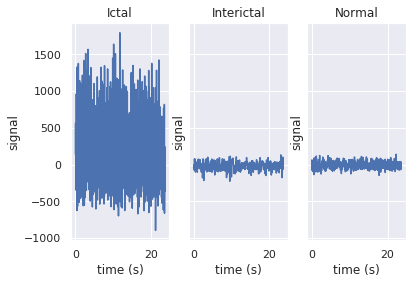

In [2]:
# Group together classes (Z, O), (N, F), (S) as normal, interictal, ictal
eeg["classes"] = eeg["classes"].astype("U16") #  allocate memory for longer class names

eeg["classes"][np.logical_or(eeg["classes"]=="Z", eeg["classes"]=="O")] = "Normal"
eeg["classes"][np.logical_or(eeg["classes"]=="N", eeg["classes"]=="F")] = "Interictal"
eeg["classes"][eeg["classes"]=="S"] = "Ictal"

fig, ax = plt.subplots(1, len(np.unique(eeg["classes"])), sharey=True)
for label, subplot in zip(np.unique(eeg["classes"]), ax):
    i = np.where(eeg["classes"] == label)[0][0]
    subplot.plot(eeg["times"][i], eeg["measurements"][i])
    subplot.set(xlabel="time (s)", ylabel="signal", title=label)

In [3]:
import warnings
warnings.filterwarnings('ignore')

from cesium import featurize
features_to_use = ["mean",
                   "median",
                   "amplitude",
                   "maximum",
                   "minimum",
                   "std",
                   "skew"]
                   
fset_cesium = featurize.featurize_time_series(times=eeg["times"],
                                              values=eeg["measurements"],
                                              errors=None,
                                              features_to_use=features_to_use)
print(fset_cesium.head())

feature       mean median amplitude maximum minimum        std      skew
channel          0      0         0       0       0          0         0
0        -4.132048   -4.0     143.5   141.0  -146.0  40.411000  0.032805
1       -52.444716  -51.0     211.5   169.0  -254.0  48.812668 -0.092715
2        12.705150   13.0     165.0   184.0  -146.0  47.144789 -0.004100
3        -3.992433   -4.0     171.5   162.0  -181.0  47.072316  0.063678
4       -17.999268  -18.0     170.0   152.0  -188.0  44.910958  0.142753


In [4]:
import numpy as np
import scipy.stats

def mean_square_signal(t, m, e):
    return np.mean(m ** 2)

def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))

def variance(t, m, e):
    return np.var(m)

In [5]:
other_features = {
    "mean_square": mean_square_signal,
    "abs_diffs": abs_diffs_signal,
    "variance": variance
}

fset_others = featurize.featurize_time_series(times=eeg["times"], values=eeg["measurements"],
                                           errors=None,
                                           features_to_use=list(other_features.keys()),
                                           custom_functions=other_features)
print(fset_others.head())

feature  mean_square abs_diffs     variance
channel            0         0            0
0        1650.122773   46948.0  1633.048953
1        5133.124725   61118.0  2382.676526
2        2384.051989   51269.0  2222.631150
3        2231.742495   75014.0  2215.802969
4        2340.967781   52873.0  2016.994142


In [7]:
fset_all = pd.concat([fset_cesium, fset_others], axis=1, sort=False)
fset_all.head()

feature,mean,median,amplitude,maximum,minimum,std,skew,mean_square,abs_diffs,variance
channel,0,0,0,0,0,0,0,0,0,0
0,-4.132048,-4.0,143.5,141.0,-146.0,40.411000,0.032805,1650.122773,46948.0,1633.048953
1,-52.444716,-51.0,211.5,169.0,-254.0,48.812668,-0.092715,5133.124725,61118.0,2382.676526
2,12.705150,13.0,165.0,184.0,-146.0,47.144789,-0.004100,2384.051989,51269.0,2222.631150
3,-3.992433,-4.0,171.5,162.0,-181.0,47.072316,0.063678,2231.742495,75014.0,2215.802969
4,-17.999268,-18.0,170.0,152.0,-188.0,44.910958,0.142753,2340.967781,52873.0,2016.994142


In [8]:
corr_matrix = fset_all.corr()
corr_matrix.head()

,feature,mean,median,amplitude,maximum,minimum,std,skew,mean_square,abs_diffs,variance
,channel,0,0,0,0,0,0,0,0,0,0
feature,channel,,,,,,,,,,
mean,0,1.000000,0.659069,0.124352,0.166760,-0.073713,0.123375,-0.046787,0.127373,0.113178,0.136089
median,0,0.659069,1.000000,0.220845,0.090440,-0.332449,0.236200,-0.518063,0.282635,0.299343,0.287812
amplitude,0,0.124352,0.220845,1.000000,0.962284,-0.963831,0.977369,-0.020502,0.928803,0.919876,0.928998
maximum,0,0.166760,0.090440,0.962284,1.000000,-0.854975,0.929628,0.201300,0.862968,0.848549,0.863782
minimum,0,-0.073713,-0.332449,-0.963831,-0.854975,1.000000,-0.952675,0.236293,-0.925386,-0.922492,-0.924960


In [9]:
def get_final_features(threshold): 
    corr_matrix_abs = corr_matrix.abs()

    # List of all features
    all_features = [x[0] for x in corr_matrix]
    
    # List all values with high correlation
    high_corr_var = np.where(corr_matrix_abs > threshold)
    high_corr_var = [(corr_matrix_abs.columns[x][0],corr_matrix_abs.columns[y][0]) 
                     for x,y in zip(*high_corr_var) if x!=y and x<y]

    # Create list of unique first, second tuple
    a = [x[0] for x in high_corr_var]
    b = [x[1] for x in high_corr_var]

    first = list(set(a))
    second = list(set(b))

    # Subtract second tuple from first to get list of features 
    # that have low or no correlation
    low_corr = list(set(a) - set(b))

    # Check if there was any features not included from the complete list
    other_features = list(set(all_features) - set(a))

    final_features = low_corr + other_features
    return(final_features)

In [10]:
features_5 = get_final_features(0.5)
features_6 = get_final_features(0.6)
features_75 = get_final_features(0.75)

print("Threshold: 0.5 = ", features_5)
print("Threshold: 0.6 = ", features_6)
print("Threshold: 0.75 = ", features_75)

Threshold: 0.5 =  ['amplitude', 'mean', 'skew', 'variance']
Threshold: 0.6 =  ['amplitude', 'mean', 'skew', 'variance', 'median']
Threshold: 0.75 =  ['amplitude', 'skew', 'variance', 'mean', 'median']


In [11]:
# Create new dataframes with just the features we want
fset_5 = fset_all[features_5]
fset_6 = fset_all[features_6]
fset_75 = fset_all[features_75]

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
train, test = train_test_split(np.arange(len(eeg["classes"])), random_state=0)

def build_model(fset):
    models = []
    
    model_lr = LogisticRegression(random_state=0, solver='lbfgs', 
                                  multi_class='multinomial').fit(fset.iloc[train], 
                                                                 eeg["classes"][train])
    
    model_nb = GaussianNB().fit(fset.iloc[train], eeg["classes"][train])
    
    model_knn = KNeighborsClassifier(3).fit(fset.iloc[train], eeg["classes"][train])

    model_rfc = RandomForestClassifier(n_estimators=128, max_features="auto", 
                                       random_state=0).fit(fset.iloc[train], 
                                                           eeg["classes"][train])

    models = [model_lr, model_nb, model_knn, model_rfc, train, test]
    return models

In [19]:
model_5 = build_model(fset_5)
model_6 = build_model(fset_6)
model_75 = build_model(fset_75)

In [20]:
print("train: ", len(model_5[4]))
print("test: ", len(model_5[5]))

train:  375
test:  125


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
    
def predict(fset, model):
    preds_lr = model[0].predict(fset)
    preds_nb = model[1].predict(fset)
    preds_knn = model[2].predict(fset)
    preds_rfc = model[3].predict(fset)
    
    print("\nLogistic Regression: ")
    print("confusion_matrix:\n", confusion_matrix(preds_lr[test], eeg["classes"][test], labels=["Normal", "Interictal", "Ictal"]))
    print("training accuracy = {:.2%}, test accuracy = {:.2%}".format(
              accuracy_score(preds_lr[train], eeg["classes"][train]),
              accuracy_score(preds_lr[test], eeg["classes"][test])))
    print("training precision = {:.2%}, test precision = {:.2%}".format(
              precision_score(preds_lr[train], eeg["classes"][train], average='weighted'),
              precision_score(preds_lr[test], eeg["classes"][test], average='weighted')))
    print("training sensitivity = {:.2%}, test sensitivity = {:.2%}".format(
              recall_score(preds_lr[train], eeg["classes"][train], average='weighted'),
              recall_score(preds_lr[test], eeg["classes"][test], average='weighted')))
    print("training f1_score = {:.2%}, test f1_score = {:.2%}".format(
              f1_score(preds_lr[train], eeg["classes"][train], average='weighted'),
              f1_score(preds_lr[test], eeg["classes"][test], average='weighted')))
   
    print("\nNaive Bayes: ")
    print("confusion_matrix:\n", confusion_matrix(preds_nb[test], eeg["classes"][test], labels=["Normal", "Interictal", "Ictal"]))
    print("training accuracy = {:.2%}, test accuracy = {:.2%}".format(
              accuracy_score(preds_nb[train], eeg["classes"][train]),
              accuracy_score(preds_nb[test], eeg["classes"][test])))
    print("training precision = {:.2%}, test precision = {:.2%}".format(
              precision_score(preds_nb[train], eeg["classes"][train], average='weighted'),
              precision_score(preds_nb[test], eeg["classes"][test], average='weighted')))
    print("training sensitivity = {:.2%}, test sensitivity = {:.2%}".format(
              recall_score(preds_nb[train], eeg["classes"][train], average='weighted'),
              recall_score(preds_nb[test], eeg["classes"][test], average='weighted')))
    print("training f1_score = {:.2%}, test f1_score = {:.2%}".format(
              f1_score(preds_nb[train], eeg["classes"][train], average='weighted'),
              f1_score(preds_nb[test], eeg["classes"][test], average='weighted')))
    
    print("\nK-nearest Neighbors: ")
    print("confusion_matrix:\n", confusion_matrix(preds_knn[test], eeg["classes"][test], labels=["Normal", "Interictal", "Ictal"]))
    print("training accuracy = {:.2%}, test accuracy = {:.2%}".format(
              accuracy_score(preds_knn[train], eeg["classes"][train]),
              accuracy_score(preds_knn[test], eeg["classes"][test])))
    print("training precision = {:.2%}, test precision = {:.2%}".format(
              precision_score(preds_knn[train], eeg["classes"][train], average='weighted'),
              precision_score(preds_knn[test], eeg["classes"][test], average='weighted')))
    print("training sensitivity = {:.2%}, test sensitivity = {:.2%}".format(
              recall_score(preds_knn[train], eeg["classes"][train], average='weighted'),
              recall_score(preds_knn[test], eeg["classes"][test], average='weighted')))
    print("training f1_score = {:.2%}, test f1_score = {:.2%}".format(
              f1_score(preds_knn[train], eeg["classes"][train], average='weighted'),
              f1_score(preds_knn[test], eeg["classes"][test], average='weighted')))
    
    print("\nRandom Forest Classifier: ")
    print("confusion_matrix:\n", confusion_matrix(preds_rfc[test], eeg["classes"][test], labels=["Normal", "Interictal", "Ictal"]))
    print("training accuracy = {:.2%}, test accuracy = {:.2%}".format(
              accuracy_score(preds_rfc[train], eeg["classes"][train]),
              accuracy_score(preds_rfc[test], eeg["classes"][test])))
    print("training precision = {:.2%}, test precision = {:.2%}".format(
              precision_score(preds_rfc[train], eeg["classes"][train], average='weighted'),
              precision_score(preds_rfc[test], eeg["classes"][test], average='weighted')))
    print("training sensitivity = {:.2%}, test sensitivity = {:.2%}".format(
              recall_score(preds_rfc[train], eeg["classes"][train], average='weighted'),
              recall_score(preds_rfc[test], eeg["classes"][test], average='weighted'))),
    print("training f1_score = {:.2%}, test f1_score = {:.2%}".format(
              f1_score(preds_rfc[train], eeg["classes"][train], average='weighted'),
              f1_score(preds_rfc[test], eeg["classes"][test], average='weighted')))

In [22]:
predict(fset_5, model_5)


Logistic Regression: 
confusion_matrix:
 [[37 26  1]
 [10 25  3]
 [ 0  3 20]]
training accuracy = 61.33%, test accuracy = 65.60%
training precision = 66.41%, test precision = 69.71%
training sensitivity = 61.33%, test sensitivity = 65.60%
training f1_score = 62.41%, test f1_score = 66.31%

Naive Bayes: 
confusion_matrix:
 [[46 44  0]
 [ 1  8  7]
 [ 0  2 17]]
training accuracy = 55.20%, test accuracy = 56.80%
training precision = 78.01%, test precision = 83.13%
training sensitivity = 55.20%, test sensitivity = 56.80%
training f1_score = 61.91%, test f1_score = 63.29%

K-nearest Neighbors: 
confusion_matrix:
 [[25 28  2]
 [22 22  2]
 [ 0  4 20]]
training accuracy = 80.53%, test accuracy = 53.60%
training precision = 81.13%, test precision = 54.40%
training sensitivity = 80.53%, test sensitivity = 53.60%
training f1_score = 80.74%, test f1_score = 53.76%

Random Forest Classifier: 
confusion_matrix:
 [[31  5  1]
 [16 47  2]
 [ 0  2 21]]
training accuracy = 100.00%, test accuracy = 79.20%

In [23]:
predict(fset_6, model_6)


Logistic Regression: 
confusion_matrix:
 [[45 45  0]
 [ 2  8  4]
 [ 0  1 20]]
training accuracy = 57.07%, test accuracy = 58.40%
training precision = 76.61%, test precision = 84.60%
training sensitivity = 57.07%, test sensitivity = 58.40%
training f1_score = 62.47%, test f1_score = 64.87%

Naive Bayes: 
confusion_matrix:
 [[46 44  0]
 [ 1  9  6]
 [ 0  1 18]]
training accuracy = 54.67%, test accuracy = 58.40%
training precision = 77.26%, test precision = 84.00%
training sensitivity = 54.67%, test sensitivity = 58.40%
training f1_score = 61.25%, test f1_score = 64.37%

K-nearest Neighbors: 
confusion_matrix:
 [[24 27  2]
 [23 23  2]
 [ 0  4 20]]
training accuracy = 79.73%, test accuracy = 53.60%
training precision = 80.39%, test precision = 54.01%
training sensitivity = 79.73%, test sensitivity = 53.60%
training f1_score = 79.96%, test f1_score = 53.67%

Random Forest Classifier: 
confusion_matrix:
 [[33  7  1]
 [14 43  2]
 [ 0  4 21]]
training accuracy = 100.00%, test accuracy = 77.60%

In [24]:
predict(fset_75, model_75)


Logistic Regression: 
confusion_matrix:
 [[45 45  0]
 [ 2  8  4]
 [ 0  1 20]]
training accuracy = 57.07%, test accuracy = 58.40%
training precision = 76.61%, test precision = 84.60%
training sensitivity = 57.07%, test sensitivity = 58.40%
training f1_score = 62.47%, test f1_score = 64.87%

Naive Bayes: 
confusion_matrix:
 [[46 44  0]
 [ 1  9  6]
 [ 0  1 18]]
training accuracy = 54.67%, test accuracy = 58.40%
training precision = 77.26%, test precision = 84.00%
training sensitivity = 54.67%, test sensitivity = 58.40%
training f1_score = 61.25%, test f1_score = 64.37%

K-nearest Neighbors: 
confusion_matrix:
 [[24 27  2]
 [23 23  2]
 [ 0  4 20]]
training accuracy = 79.73%, test accuracy = 53.60%
training precision = 80.39%, test precision = 54.01%
training sensitivity = 79.73%, test sensitivity = 53.60%
training f1_score = 79.96%, test f1_score = 53.67%

Random Forest Classifier: 
confusion_matrix:
 [[32  6  1]
 [15 44  2]
 [ 0  4 21]]
training accuracy = 100.00%, test accuracy = 77.60%

In [25]:
fset_5.head()

feature,amplitude,mean,skew,variance
channel,0,0,0,0
0,143.5,-4.132048,0.032805,1633.048953
1,211.5,-52.444716,-0.092715,2382.676526
2,165.0,12.705150,-0.004100,2222.631150
3,171.5,-3.992433,0.063678,2215.802969
4,170.0,-17.999268,0.142753,2016.994142


In [44]:
# Using Keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Conv1D, MaxPooling1D, Flatten
from keras.utils.np_utils import to_categorical

from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(eeg["measurements"], eeg["classes"], test_size=0.2, random_state=42)

X_train = np.reshape(X_train, (400,4097))
X_test = np.reshape(X_test, (100,4097))

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)
integer_encoded_test = label_encoder.fit_transform(y_test)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)

onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
onehot_encoded_test = onehot_encoder.fit_transform(integer_encoded_test)

y_train = onehot_encoded
y_train = np.reshape(y_train, (400, 1, 3))

y_test = onehot_encoded_test
y_test = np.reshape(y_test, (100, 1, 3))

In [45]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, input_shape=(None,1)))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2 ))
model.add(Dense(1000, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 1000)        33000     
_________________________________________________________________
dense_4 (Dense)              (None, None, 3)           3003      
Total params: 41,347
Trainable params: 41,347
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
BATCH_SIZE = 400
EPOCHS = 300

# fset_5_array = fset_5.values
# X_train_final = np.reshape(4097,1,400)

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

ValueError: Error when checking input: expected conv1d_3_input to have 3 dimensions, but got array with shape (400, 4097)

In [280]:
model.evaluate(X_test, y_test, batch_size=32, verbose=0)

[0.5301502513885498, 0.7700342297554016]

In [289]:
test

array([ 90, 254, 283, 445, 461,  15, 316, 489, 159, 153, 241, 250, 390,
       289, 171, 329, 468, 355, 154,  37, 205, 366, 240, 108,  45, 438,
        21, 367,  96, 233, 428, 118, 124, 191, 374, 492, 311, 451, 353,
       238, 322,  46, 403, 221,  76,   1, 213, 325, 418, 102, 363, 170,
       343, 144, 132,  12, 327, 173, 224, 342,  78, 276, 387, 425, 301,
       196,  10, 469, 271,  75, 142,  65, 340, 484, 175, 362, 264, 100,
       491, 295, 300, 235, 475, 219, 330, 326, 421, 157, 348,  54, 220,
       402, 379, 200, 179, 372,  56, 440,  60, 208, 107, 336,  71, 474,
         6, 412, 113, 236, 299, 155, 272,   7, 137,   8, 463, 432, 375,
       284, 210, 188, 430,  49, 134, 365, 413])

In [288]:
X_test

array([[[-24.],
        [-15.],
        [ -5.],
        ...,
        [-57.],
        [-54.],
        [-30.]],

       [[-48.],
        [-52.],
        [-63.],
        ...,
        [ -5.],
        [ -9.],
        [  0.]],

       [[ 49.],
        [ 54.],
        [ 62.],
        ...,
        [ 12.],
        [ 13.],
        [ 40.]],

       ...,

       [[ 39.],
        [ 41.],
        [ 43.],
        ...,
        [-29.],
        [-16.],
        [  1.]],

       [[249.],
        [218.],
        [176.],
        ...,
        [367.],
        [299.],
        [ 26.]],

       [[ 34.],
        [ 34.],
        [ 31.],
        ...,
        [ -7.],
        [-20.],
        [ 91.]]])

In [287]:
print(fset_5.iloc[test])

feature amplitude       mean       variance      skew
channel         0          0              0         0
90          144.5 -28.239688    1987.303058 -0.046706
254          99.0  -8.651452     916.789913 -0.347122
283         254.0 -52.632170    4541.735582 -0.054374
445         450.0   6.621186   20847.731531 -0.299523
461         246.0  -7.891140   11268.679387  0.303489
15          184.0   5.012692    2220.598814 -0.195767
316         114.5  -3.758848    1391.233034 -0.257820
489         945.5   3.282158   67213.825195  0.216552
159         342.0 -19.309007    9676.057310  0.134387
153         141.5  56.330242    1522.331019  0.182110
241          65.5  -8.377593     346.218419 -0.317217
250         405.5   0.377105    9239.074047  0.116386
390         275.0   5.626312    7764.221353 -0.061711
289          92.5  -3.938492     517.421650 -0.434865
171         151.0   2.873810    1704.686785 -0.007218
329         528.5 -38.859409   20723.485726  2.307538
468         335.5 -53.463754

In [290]:
X_train, X_test, y_train, y_test = train_test_split(eeg["measurements"], eeg["classes"], test_size=0.2, random_state=42)

In [303]:
X_test = np.reshape(X_test, (4097,100))

In [304]:
X_test

array([[-24., -15.,  -5., ..., -36., -33., -32.],
       [-31., -37., -52., ..., 112., 118., 118.],
       [116., 118., 120., ...,  28.,  27.,  31.],
       ...,
       [ 18.,  30.,  17., ..., -29., -43., -53.],
       [-65., -75., -71., ..., -61., -44., -27.],
       [-11.,  -5.,  -7., ...,  -7., -20.,  91.]])

In [305]:
test

array([ 90, 254, 283, 445, 461,  15, 316, 489, 159, 153, 241, 250, 390,
       289, 171, 329, 468, 355, 154,  37, 205, 366, 240, 108,  45, 438,
        21, 367,  96, 233, 428, 118, 124, 191, 374, 492, 311, 451, 353,
       238, 322,  46, 403, 221,  76,   1, 213, 325, 418, 102, 363, 170,
       343, 144, 132,  12, 327, 173, 224, 342,  78, 276, 387, 425, 301,
       196,  10, 469, 271,  75, 142,  65, 340, 484, 175, 362, 264, 100,
       491, 295, 300, 235, 475, 219, 330, 326, 421, 157, 348,  54, 220,
       402, 379, 200, 179, 372,  56, 440,  60, 208, 107, 336,  71, 474,
         6, 412, 113, 236, 299, 155, 272,   7, 137,   8, 463, 432, 375,
       284, 210, 188, 430,  49, 134, 365, 413])

In [307]:
fset_5.iloc[X_test[0]]

feature,amplitude,mean,variance,skew
channel,0,0,0,0
476,984.5,-33.119112,86099.876952,-0.049577
485,590.5,-5.672687,45599.431797,0.288864
495,876.5,12.870393,110526.604876,-0.472757
499,1396.0,47.100073,228947.748833,-1.347758
4,170.0,-17.999268,2016.994142,0.142753
3,171.5,-3.992433,2215.802969,0.063678
6,162.0,-13.334635,2139.935127,0.003179
10,149.5,-13.600195,1475.830881,-0.120190
11,138.5,-14.408348,1567.651900,-0.091485


In [314]:
X_test

array([[-24., -15.,  -5., ..., -57., -54., -30.],
       [-48., -52., -63., ...,  -5.,  -9.,   0.],
       [ 49.,  54.,  62., ...,  12.,  13.,  40.],
       ...,
       [ 39.,  41.,  43., ..., -29., -16.,   1.],
       [249., 218., 176., ..., 367., 299.,  26.],
       [ 34.,  34.,  31., ...,  -7., -20.,  91.]])